In [1]:
path = r'C:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\RESSOURCES'

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 18s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 21s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 11s
Installments payments df shape: (339587, 26)
Process installments payments - done in 22s
Credit card balance df shape: (103558, 109)
Process credit card balance - done in 13s
DataFrame complet sauvegardé dans 'full_dataset.csv'
Starting LightGBM. Train shape: (307507, 766), test shape: (48744, 766)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.797011	training's binary_logloss: 0.234882	valid_1's auc: 0.776223	valid_1's binary_logloss: 0.24673
[400]	training's auc: 0.819433	training's binary_logloss: 0.225331	valid_1's auc: 0.786429	valid_1's binary_logloss: 0.242771
[600]	training's auc: 0.834135	training's binary_logloss: 0.219315	valid_1's auc: 0.790179	valid

C:\Users\lenovo\AppData\Local\Temp\ipykernel_15720\3797559951.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = sub_preds


Run LightGBM with kfold - done in 5247s
Full model run - done in 5489s


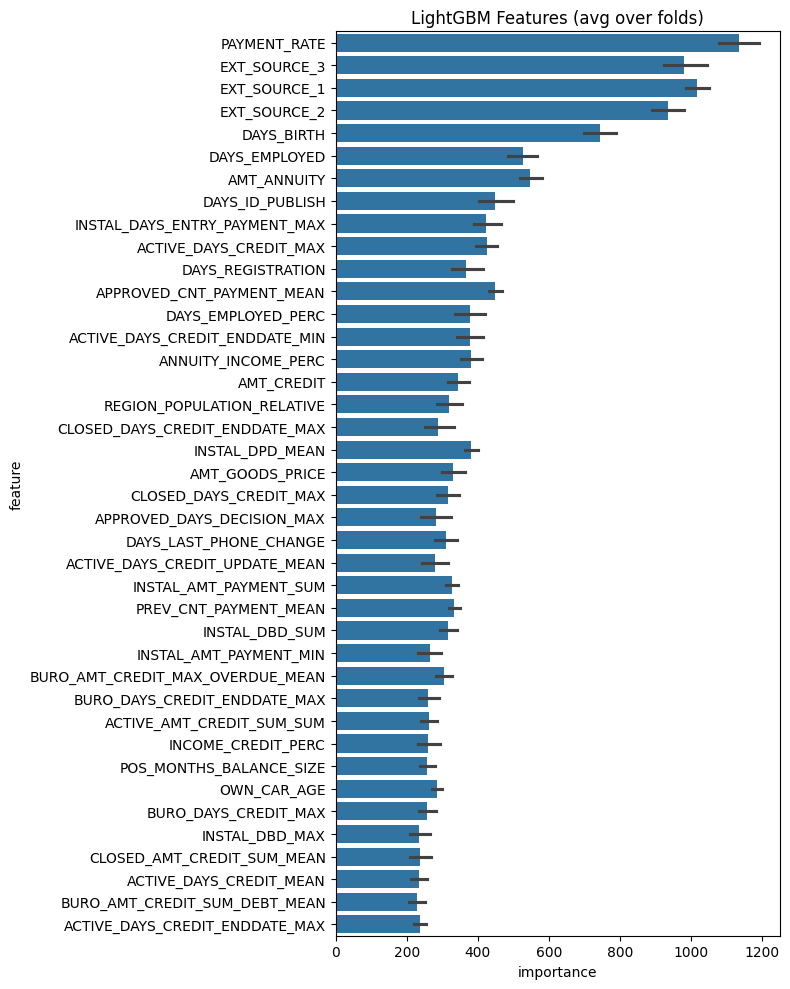

In [2]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import lightgbm as lgb # MODIFICATION
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(path+r'\application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(path+r'\application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df], axis=0).reset_index() # MODIFICATION
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(path+r'\bureau.csv', nrows = num_rows)
    bb = pd.read_csv(path+r'\bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path+r'\previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path+r'\POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path+r'\installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True): # FONCTION MODIFIEE POUR GERER LES COLONNES CATEGORIELLES
    cc = pd.read_csv(path+r'\credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    
    # Séparer les colonnes numériques et catégorielles
    num_cols = [col for col in cc.columns if col not in cat_cols and col != 'SK_ID_CURR' and col != 'SK_ID_PREV']
    
    # Agrégations pour colonnes numériques
    num_aggs = {}
    for col in num_cols:
        num_aggs[col] = ['min', 'max', 'mean', 'sum', 'var']
        
    # Agrégations pour colonnes catégorielles
    cat_aggs = {}
    for col in cat_cols:
        cat_aggs[col] = ['mean']  # uniquement la moyenne pour les colonnes catégorielles
    
    # Combiner les agrégations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    
    # Appliquer les agrégations séparément
    num_agg = cc[['SK_ID_CURR'] + num_cols].groupby('SK_ID_CURR').agg(num_aggs)
    cat_agg = cc[['SK_ID_CURR'] + cat_cols].groupby('SK_ID_CURR').agg(cat_aggs)
    
    # Renommer les colonnes
    num_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in num_agg.columns.tolist()])
    cat_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cat_agg.columns.tolist()])
    
    # Combiner les résultats
    cc_agg = num_agg.join(cat_agg, on='SK_ID_CURR', how='left')
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    del cc, num_agg, cat_agg
    gc.collect()
    return cc_agg

def clean_column_names(df): # FONCTION RAJOUTER POUR NETTOYER LES NOMS DE COLONNES POUR LIGHT GBM
    """
    Nettoie les noms de colonnes pour les rendre compatibles avec LightGBM
    """
    def clean_name(name):
        # Remplace les caractères spéciaux par des underscores
        import re
        name = re.sub(r'[^A-Za-z0-9_]+', '_', str(name))
        # Évite les underscores doubles
        name = re.sub(r'_+', '_', name)
        # Enlève les underscores au début et à la fin
        name = name.strip('_')
        return name
    
    df.columns = [clean_name(col) for col in df.columns]
    return df


# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Nettoyer les noms de colonnes dès le début
    df = clean_column_names(df) # AJOUT DE CETTE LIGNE
    
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf = LGBMClassifier(
            n_jobs=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1
        )

        clf.fit(train_x, train_y, 
            eval_set=[(train_x, train_y), (valid_x, valid_y)],
            eval_metric='auc',
            callbacks=[
                lgb.early_stopping(stopping_rounds=200),
                lgb.log_evaluation(period=200)
            ]
        )

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug = False, save_df = True):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    ## AJOUT ## 
    # Sauvegarde du DataFrame avant modélisation si demandé
    if save_df:
        df.to_csv('full_dataset.csv', index=False)
        print("DataFrame complet sauvegardé dans 'full_dataset.csv'")
    ## FIN AJOUT ## 
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)
    
if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        final_df = main()

J'ai modifié plusieurs lignes de ce notebook du à des dépréciations depuis sa création

In [12]:
DF_results = pd.read_csv(r'C:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\submission_kernel02.csv')

In [13]:
DF_results

,SK_ID_CURR,TARGET
0,100001,0.033534
1,100005,0.146321
2,100013,0.029158
3,100028,0.036100
4,100038,0.147196
...,...,...
48739,456221,0.045465
48740,456222,0.060997
48741,456223,0.007718
48742,456224,0.025056


Les résultats obtenus sont des probabilités. Probabilités du client de ne pas rembourser le crédit

In [14]:
DF_final = pd.read_csv(r'C:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\full_dataset.csv')

In [15]:
DF_final.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356251 entries, 0 to 356250
Data columns (total 766 columns):
 #    Column                                                                 Non-Null Count   Dtype  
---   ------                                                                 --------------   -----  
 0    index                                                                  356251 non-null  int64  
 1    SK_ID_CURR                                                             356251 non-null  int64  
 2    TARGET                                                                 307507 non-null  float64
 3    CODE_GENDER                                                            356251 non-null  int64  
 4    FLAG_OWN_CAR                                                           356251 non-null  int64  
 5    FLAG_OWN_REALTY                                                        356251 non-null  int64  
 6    CNT_CHILDREN                                                      

In [16]:
DF_final.describe()

c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWa

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_COUNT
count,356251.000000,356251.000000,307507.00000,356251.000000,356251.000000,356251.000000,356251.000000,3.562510e+05,3.562510e+05,356215.000000,...,102866.000000,103558.000000,1.035580e+05,103558.000000,103558.000000,103558.000000,103558.000000,103558.000000,103558.0,103558.000000
mean,136052.869904,278128.870078,0.08073,0.660001,0.339699,0.306764,0.414312,1.701159e+05,5.877695e+05,27425.644390,...,66.276536,0.963567,5.316636e-07,0.032644,0.000143,0.000002,0.000059,0.003583,0.0,37.083683
std,93841.582375,102842.068890,0.27242,0.473709,0.473608,0.461151,0.720376,2.235080e+05,3.986253e+05,14732.860946,...,6110.026303,0.114345,7.659438e-05,0.109727,0.010525,0.000156,0.000846,0.031014,0.0,33.483627
min,0.000000,100001.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
25%,44532.000000,189065.500000,0.00000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,...,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,10.000000
50%,129384.000000,278129.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,...,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,22.000000
75%,218447.500000,367192.500000,0.00000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,...,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,75.000000
max,307510.000000,456255.000000,1.00000,1.000000,1.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,...,845673.427019,1.000000,1.190476e-02,1.000000,1.000000,0.013889,0.024390,1.000000,0.0,192.000000


# TRAITEMENT DES NAN


In [17]:
for col in DF_final.columns:
    if col != 'TARGET':
        DF_final.loc[DF_final[col].isna(), col] = DF_final[col].mean()

In [18]:
DF_final.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356251 entries, 0 to 356250
Data columns (total 766 columns):
 #    Column                                                                 Non-Null Count   Dtype  
---   ------                                                                 --------------   -----  
 0    index                                                                  356251 non-null  float64
 1    SK_ID_CURR                                                             356251 non-null  float64
 2    TARGET                                                                 307507 non-null  float64
 3    CODE_GENDER                                                            356251 non-null  float64
 4    FLAG_OWN_CAR                                                           356251 non-null  float64
 5    FLAG_OWN_REALTY                                                        356251 non-null  float64
 6    CNT_CHILDREN                                                      

In [19]:
DF_final['SK_ID_CURR'] = DF_final['SK_ID_CURR'].astype(int)

In [20]:
DF_final = DF_final.set_index('SK_ID_CURR')

In [21]:
DF_final.head(5)

,index,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.0,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,...,66.276536,0.963567,5.316636e-07,0.032644,0.000143,0.000002,0.000059,0.003583,0.0,37.083683
100003,1.0,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,66.276536,0.963567,5.316636e-07,0.032644,0.000143,0.000002,0.000059,0.003583,0.0,37.083683
100004,2.0,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,...,66.276536,0.963567,5.316636e-07,0.032644,0.000143,0.000002,0.000059,0.003583,0.0,37.083683
100006,3.0,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,...,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.000000
100007,4.0,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,...,66.276536,0.963567,5.316636e-07,0.032644,0.000143,0.000002,0.000059,0.003583,0.0,37.083683


In [22]:
DF_final = DF_final.drop('index',axis=1)

In [23]:
DF_final

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,...,66.276536,0.963567,5.316636e-07,0.032644,0.000143,0.000002,0.000059,0.003583,0.0,37.083683
100003,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,66.276536,0.963567,5.316636e-07,0.032644,0.000143,0.000002,0.000059,0.003583,0.0,37.083683
100004,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,...,66.276536,0.963567,5.316636e-07,0.032644,0.000143,0.000002,0.000059,0.003583,0.0,37.083683
100006,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.000000
100007,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,...,66.276536,0.963567,5.316636e-07,0.032644,0.000143,0.000002,0.000059,0.003583,0.0,37.083683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221,NaN,1.0,0.0,0.0,0.0,121500.0,412560.0,17473.5,270000.0,0.002042,...,66.276536,0.963567,5.316636e-07,0.032644,0.000143,0.000002,0.000059,0.003583,0.0,37.083683
456222,NaN,1.0,0.0,1.0,2.0,157500.0,622413.0,31909.5,495000.0,0.035792,...,66.276536,0.963567,5.316636e-07,0.032644,0.000143,0.000002,0.000059,0.003583,0.0,37.083683
456223,NaN,1.0,1.0,0.0,1.0,202500.0,315000.0,33205.5,315000.0,0.026392,...,66.276536,0.963567,5.316636e-07,0.032644,0.000143,0.000002,0.000059,0.003583,0.0,37.083683


In [24]:
DF_final_test = DF_final.loc[DF_final['TARGET'].isna()]

In [25]:
DF_final_train = DF_final.loc[~DF_final['TARGET'].isna()]


In [26]:
DF_final_train.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 100002 to 456255
Data columns (total 764 columns):
 #    Column                                                                 Non-Null Count   Dtype  
---   ------                                                                 --------------   -----  
 0    TARGET                                                                 307507 non-null  float64
 1    CODE_GENDER                                                            307507 non-null  float64
 2    FLAG_OWN_CAR                                                           307507 non-null  float64
 3    FLAG_OWN_REALTY                                                        307507 non-null  float64
 4    CNT_CHILDREN                                                           307507 non-null  float64
 5    AMT_INCOME_TOTAL                                                       307507 non-null  float64
 6    AMT_CREDIT                                                        

In [27]:
DF_final_test.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 48744 entries, 100001 to 456250
Data columns (total 764 columns):
 #    Column                                                                 Non-Null Count  Dtype  
---   ------                                                                 --------------  -----  
 0    TARGET                                                                 0 non-null      float64
 1    CODE_GENDER                                                            48744 non-null  float64
 2    FLAG_OWN_CAR                                                           48744 non-null  float64
 3    FLAG_OWN_REALTY                                                        48744 non-null  float64
 4    CNT_CHILDREN                                                           48744 non-null  float64
 5    AMT_INCOME_TOTAL                                                       48744 non-null  float64
 6    AMT_CREDIT                                                             4874

In [28]:
DF_final_train=DF_final_train.drop(['index'],axis=1)

KeyError: "['index'] not found in axis"

In [ ]:
DF_final_test=DF_final_test.drop(['index'],axis=1)

In [ ]:
DF_final_train.info(show_counts=True, verbose=True)

In [ ]:
DF_final_test.info(show_counts=True, verbose=True)

In [29]:
DF_final_test = DF_final_test.drop(['TARGET'],axis = 1)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Séparation features (X) et target (y)
X = DF_final_train.drop('TARGET', axis=1)
y = DF_final_train['TARGET']


In [31]:
# 1. D'abord vérifions les types de données
print("Types de données dans X :")
print(X.dtypes)

# 2. Sélectionnons uniquement les colonnes numériques
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns

# 3. Maintenant vérifions les infinis dans les colonnes numériques
print("\nColonnes avec des infinis :")
inf_columns = []
for col in numeric_columns:
    if (X[col] == np.inf).any() or (X[col] == -np.inf).any():
        inf_columns.append(col)
print(inf_columns)

# 4. Nettoyons les données
for col in numeric_columns:
    # Remplacer les infinis par NaN
    X[col] = X[col].replace([np.inf, -np.inf], np.nan)
    # Remplacer les NaN par la moyenne
    X[col] = X[col].fillna(X[col].mean())

Types de données dans X :
CODE_GENDER                                   float64
FLAG_OWN_CAR                                  float64
FLAG_OWN_REALTY                               float64
CNT_CHILDREN                                  float64
AMT_INCOME_TOTAL                              float64
                                               ...   
CC_NAME_CONTRACT_STATUS_Refused_MEAN          float64
CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN    float64
CC_NAME_CONTRACT_STATUS_Signed_MEAN           float64
CC_NAME_CONTRACT_STATUS_nan_MEAN              float64
CC_COUNT                                      float64
Length: 763, dtype: object

Colonnes avec des infinis :
['PREV_APP_CREDIT_PERC_MAX', 'PREV_APP_CREDIT_PERC_MEAN', 'REFUSED_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_SUM']


In [32]:
X.to_csv('DF_final_train.csv', index=True)

In [33]:
# Import nécessaire
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 1. Séparation train/test stratifiée
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

# 2. Scaling avec conservation de l'index
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    index=X_train.index,
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    index=X_test.index,
    columns=X_test.columns
)

# 3. Modèle avec pondération
model = LogisticRegression(
    class_weight={0:1, 1:10},
    random_state=42
)

# 4. Validation croisée stratifiée
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = []
for train_idx, val_idx in skf.split(X_train_scaled, y_train):
    # Conversion en array numpy pour éviter les problèmes d'index
    X_train_fold = X_train_scaled.iloc[train_idx].values
    y_train_fold = y_train.iloc[train_idx].values
    X_val_fold = X_train_scaled.iloc[val_idx].values
    y_val_fold = y_train.iloc[val_idx].values
    
    # Entraînement et évaluation
    model.fit(X_train_fold, y_train_fold)
    score = model.score(X_val_fold, y_val_fold)
    scores.append(score)

c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

In [34]:
scores

[0.7406353529399808,
 0.7365703949106726,
 0.7398833357045589,
 0.7422410113615577,
 0.7397817117538261]

In [35]:
model_final = LogisticRegression(class_weight={0:1, 1:10}, random_state=42)
model_final.fit(X_train_scaled, y_train)

c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 1, 1: 10}, random_state=42)

In [36]:
X_pred = DF_final_test

In [37]:
# 1. D'abord vérifions les types de données
print("Types de données dans X :")
print(X_pred.dtypes)

# 2. Sélectionnons uniquement les colonnes numériques
numeric_columns = X_pred.select_dtypes(include=['float64', 'int64']).columns

# 3. Maintenant vérifions les infinis dans les colonnes numériques
print("\nColonnes avec des infinis :")
inf_columns = []
for col in numeric_columns:
    if (X_pred[col] == np.inf).any() or (X_pred[col] == -np.inf).any():
        inf_columns.append(col)
print(inf_columns)

# 4. Nettoyons les données
for col in numeric_columns:
    # Remplacer les infinis par NaN
    X_pred[col] = X_pred[col].replace([np.inf, -np.inf], np.nan)
    # Remplacer les NaN par la moyenne
    X_pred[col] = X_pred[col].fillna(X[col].mean())

Types de données dans X :
CODE_GENDER                                   float64
FLAG_OWN_CAR                                  float64
FLAG_OWN_REALTY                               float64
CNT_CHILDREN                                  float64
AMT_INCOME_TOTAL                              float64
                                               ...   
CC_NAME_CONTRACT_STATUS_Refused_MEAN          float64
CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN    float64
CC_NAME_CONTRACT_STATUS_Signed_MEAN           float64
CC_NAME_CONTRACT_STATUS_nan_MEAN              float64
CC_COUNT                                      float64
Length: 763, dtype: object

Colonnes avec des infinis :
['PREV_APP_CREDIT_PERC_MAX', 'PREV_APP_CREDIT_PERC_MEAN', 'REFUSED_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_SUM']


In [38]:
X_pred_scaled = pd.DataFrame(
    scaler.transform(X_pred),
    index=X_pred.index,
    columns=X_pred.columns
)

In [39]:
y_pred = model_final.predict(X_test_scaled)

In [40]:
y_pred

array([0., 0., 1., ..., 0., 0., 1.], shape=(61502,))

In [41]:
y_prob = model_final.predict_proba(X_test_scaled)

In [42]:
y_prob

array([[0.58543393, 0.41456607],
       [0.68595535, 0.31404465],
       [0.48854146, 0.51145854],
       ...,
       [0.81643707, 0.18356293],
       [0.72469306, 0.27530694],
       [0.30014675, 0.69985325]], shape=(61502, 2))

# ANALYSE DES CLIENTS DEFAILLANTS MAL CLASSES AINSI QUE DE LEUR PROBA RESPECTIVES 

In [43]:
# Obtenir les prédictions et probabilités
y_pred = model_final.predict(X_test_scaled)
y_prob = model_final.predict_proba(X_test_scaled)

# Créer un DataFrame pour l'analyse
results_df = pd.DataFrame({
    'Vraie_Classe': y_test,
    'Prediction': y_pred,
    'Probabilite_Defaut': y_prob[:, 1]  # Probabilité de la classe 1 (défaillant)
})

# Identifier les faux négatifs (clients défaillants classés comme non-défaillants)
faux_negatifs = results_df[
    (results_df['Vraie_Classe'] == 1) & 
    (results_df['Prediction'] == 0)
].sort_values('Probabilite_Defaut', ascending=False)

print("Nombre de faux négatifs:", len(faux_negatifs))
print("\nDétail des faux négatifs:")
print(faux_negatifs.head(10))  # Afficher les 10 premiers cas

Nombre de faux négatifs: 1703

Détail des faux négatifs:
            Vraie_Classe  Prediction  Probabilite_Defaut
SK_ID_CURR                                              
335120               1.0         0.0            0.499615
298589               1.0         0.0            0.499589
229004               1.0         0.0            0.499464
142631               1.0         0.0            0.498858
408141               1.0         0.0            0.498649
294233               1.0         0.0            0.498428
136237               1.0         0.0            0.498240
230961               1.0         0.0            0.497619
325776               1.0         0.0            0.497555
432883               1.0         0.0            0.497550


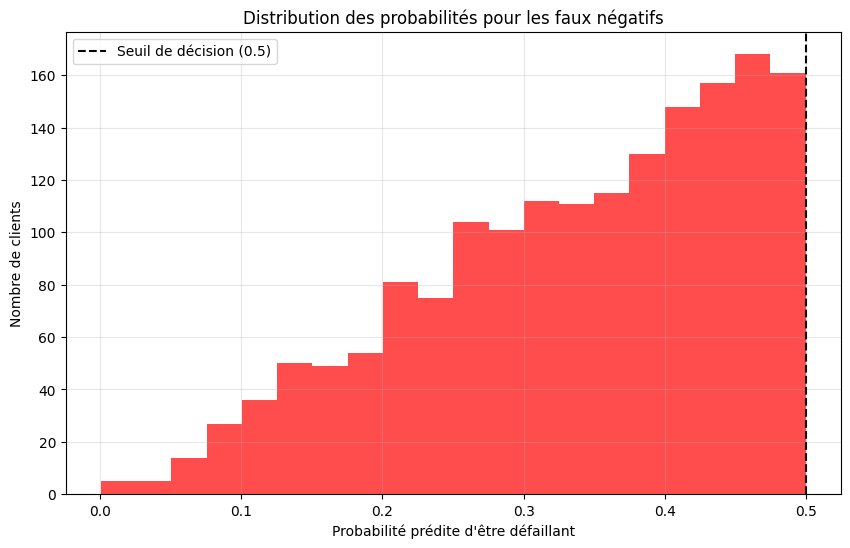

In [44]:
# Création de l'histogramme des faux négatifs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(faux_negatifs['Probabilite_Defaut'], bins=20, color='red', alpha=0.7)
plt.title('Distribution des probabilités pour les faux négatifs')
plt.xlabel('Probabilité prédite d\'être défaillant')
plt.ylabel('Nombre de clients')
plt.axvline(x=0.5, color='black', linestyle='--', label='Seuil de décision (0.5)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# TEST DE DIFFERENTES VALEURS DE SEUIL AVEC RECALL COMME METRIQUE

In [45]:
from sklearn.metrics import recall_score, confusion_matrix
import numpy as np

# Obtenir les probabilités de prédiction
y_prob = model_final.predict_proba(X_test_scaled)

# Tester différents seuils
seuils = np.arange(0.2, 0.51, 0.01)
resultats = []

for seuil in seuils:
    # Prédictions avec le seuil actuel
    y_pred = (y_prob[:, 1] >= seuil).astype(int)
    # Calcul du recall
    recall = recall_score(y_test, y_pred)
    resultats.append({
        'seuil': seuil,
        'recall': recall
    })

# Afficher les résultats pour chaque seuil
for res in resultats:
    print(f"Seuil: {res['seuil']:.2f}, Recall: {res['recall']:.4f}")

# Trouver le meilleur seuil
meilleur_seuil = max(resultats, key=lambda x: x['recall'])
print(f"\nMeilleur seuil: {meilleur_seuil['seuil']:.2f} avec un recall de {meilleur_seuil['recall']:.4f}")

# Sauvegarder le meilleur modèle (avec son seuil)
meilleur_modele = {
    'model': model_final,
    'seuil': meilleur_seuil['seuil']
}

# Faire les prédictions avec le meilleur seuil
meilleures_predictions = (y_prob[:, 1] >= meilleur_seuil['seuil']).astype(int)

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, meilleures_predictions)
print("\nMatrice de confusion avec le meilleur seuil:")
print(conf_matrix)

Seuil: 0.20, Recall: 0.9519
Seuil: 0.21, Recall: 0.9462
Seuil: 0.22, Recall: 0.9382
Seuil: 0.23, Recall: 0.9333
Seuil: 0.24, Recall: 0.9267
Seuil: 0.25, Recall: 0.9202
Seuil: 0.26, Recall: 0.9128
Seuil: 0.27, Recall: 0.9037
Seuil: 0.28, Recall: 0.8943
Seuil: 0.29, Recall: 0.8860
Seuil: 0.30, Recall: 0.8790
Seuil: 0.31, Recall: 0.8695
Seuil: 0.32, Recall: 0.8610
Seuil: 0.33, Recall: 0.8520
Seuil: 0.34, Recall: 0.8417
Seuil: 0.35, Recall: 0.8338
Seuil: 0.36, Recall: 0.8270
Seuil: 0.37, Recall: 0.8161
Seuil: 0.38, Recall: 0.8056
Seuil: 0.39, Recall: 0.7948
Seuil: 0.40, Recall: 0.7847
Seuil: 0.41, Recall: 0.7724
Seuil: 0.42, Recall: 0.7593
Seuil: 0.43, Recall: 0.7501
Seuil: 0.44, Recall: 0.7347
Seuil: 0.45, Recall: 0.7231
Seuil: 0.46, Recall: 0.7106
Seuil: 0.47, Recall: 0.6965
Seuil: 0.48, Recall: 0.6816
Seuil: 0.49, Recall: 0.6687
Seuil: 0.50, Recall: 0.6570

Meilleur seuil: 0.20 avec un recall de 0.9519

Matrice de confusion avec le meilleur seuil:
[[15282 41255]
 [  239  4726]]


# MEME CHOSE MAIS AVEC LE F1 SCORE

In [46]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# Obtenir les probabilités de prédiction
y_prob = model_final.predict_proba(X_test_scaled)

# Tester différents seuils
seuils = np.arange(0.2, 0.51, 0.01)
resultats = []

for seuil in seuils:
    # Prédictions avec le seuil actuel
    y_pred = (y_prob[:, 1] >= seuil).astype(int)
    # Calcul du F1-score
    f1 = f1_score(y_test, y_pred)
    resultats.append({
        'seuil': seuil,
        'f1_score': f1
    })

# Afficher les résultats pour chaque seuil
for res in resultats:
    print(f"Seuil: {res['seuil']:.2f}, F1-Score: {res['f1_score']:.4f}")

# Trouver le meilleur seuil
meilleur_seuil = max(resultats, key=lambda x: x['f1_score'])
print(f"\nMeilleur seuil: {meilleur_seuil['seuil']:.2f} avec un F1-Score de {meilleur_seuil['f1_score']:.4f}")

# Sauvegarder le meilleur modèle (avec son seuil)
meilleur_modele = {
    'model': model_final,
    'seuil': meilleur_seuil['seuil']
}

# Faire les prédictions avec le meilleur seuil
meilleures_predictions = (y_prob[:, 1] >= meilleur_seuil['seuil']).astype(int)

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, meilleures_predictions)
print("\nMatrice de confusion avec le meilleur seuil:")
print(conf_matrix)

Seuil: 0.20, F1-Score: 0.1855
Seuil: 0.21, F1-Score: 0.1886
Seuil: 0.22, F1-Score: 0.1913
Seuil: 0.23, F1-Score: 0.1949
Seuil: 0.24, F1-Score: 0.1984
Seuil: 0.25, F1-Score: 0.2020
Seuil: 0.26, F1-Score: 0.2053
Seuil: 0.27, F1-Score: 0.2084
Seuil: 0.28, F1-Score: 0.2115
Seuil: 0.29, F1-Score: 0.2149
Seuil: 0.30, F1-Score: 0.2188
Seuil: 0.31, F1-Score: 0.2220
Seuil: 0.32, F1-Score: 0.2253
Seuil: 0.33, F1-Score: 0.2292
Seuil: 0.34, F1-Score: 0.2328
Seuil: 0.35, F1-Score: 0.2369
Seuil: 0.36, F1-Score: 0.2415
Seuil: 0.37, F1-Score: 0.2449
Seuil: 0.38, F1-Score: 0.2483
Seuil: 0.39, F1-Score: 0.2518
Seuil: 0.40, F1-Score: 0.2562
Seuil: 0.41, F1-Score: 0.2600
Seuil: 0.42, F1-Score: 0.2631
Seuil: 0.43, F1-Score: 0.2678
Seuil: 0.44, F1-Score: 0.2702
Seuil: 0.45, F1-Score: 0.2740
Seuil: 0.46, F1-Score: 0.2776
Seuil: 0.47, F1-Score: 0.2805
Seuil: 0.48, F1-Score: 0.2832
Seuil: 0.49, F1-Score: 0.2868
Seuil: 0.50, F1-Score: 0.2907

Meilleur seuil: 0.50 avec un F1-Score de 0.2907

Matrice de confusion

# MEME CHOSE AVEC UN F1 SCORE PONDERE

In [47]:
from sklearn.metrics import confusion_matrix
import numpy as np

def custom_f1_score(y_true, y_pred, fn_weight=10, fp_weight=1):
    # Calcul de la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calcul de la précision et du recall pondérés
    weighted_precision = tp / (tp + fp_weight * fp) if (tp + fp_weight * fp) > 0 else 0
    weighted_recall = tp / (tp + fn_weight * fn) if (tp + fn_weight * fn) > 0 else 0
    
    # Calcul du F1-score pondéré
    if weighted_precision + weighted_recall > 0:
        weighted_f1 = 2 * (weighted_precision * weighted_recall) / (weighted_precision + weighted_recall)
    else:
        weighted_f1 = 0
        
    return weighted_f1

# Test des différents seuils avec le F1-score pondéré
y_prob = model_final.predict_proba(X_test_scaled)
seuils = np.arange(0.2, 0.51, 0.01)
resultats = []

for seuil in seuils:
    y_pred = (y_prob[:, 1] >= seuil).astype(int)
    weighted_f1 = custom_f1_score(y_test, y_pred, fn_weight=10, fp_weight=1)
    resultats.append({
        'seuil': seuil,
        'weighted_f1': weighted_f1
    })

# Afficher les résultats
for res in resultats:
    print(f"Seuil: {res['seuil']:.2f}, F1-Score pondéré: {res['weighted_f1']:.4f}")

# Trouver le meilleur seuil
meilleur_seuil = max(resultats, key=lambda x: x['weighted_f1'])
print(f"\nMeilleur seuil: {meilleur_seuil['seuil']:.2f} avec un F1-Score pondéré de {meilleur_seuil['weighted_f1']:.4f}")

# Matrice de confusion pour le meilleur seuil
meilleures_predictions = (y_prob[:, 1] >= meilleur_seuil['seuil']).astype(int)
conf_matrix = confusion_matrix(y_test, meilleures_predictions)
print("\nMatrice de confusion avec le meilleur seuil:")
print(conf_matrix)

Seuil: 0.20, F1-Score pondéré: 0.1780
Seuil: 0.21, F1-Score pondéré: 0.1800
Seuil: 0.22, F1-Score pondéré: 0.1811
Seuil: 0.23, F1-Score pondéré: 0.1834
Seuil: 0.24, F1-Score pondéré: 0.1853
Seuil: 0.25, F1-Score pondéré: 0.1873
Seuil: 0.26, F1-Score pondéré: 0.1886
Seuil: 0.27, F1-Score pondéré: 0.1895
Seuil: 0.28, F1-Score pondéré: 0.1901
Seuil: 0.29, F1-Score pondéré: 0.1911
Seuil: 0.30, F1-Score pondéré: 0.1926
Seuil: 0.31, F1-Score pondéré: 0.1931
Seuil: 0.32, F1-Score pondéré: 0.1936
Seuil: 0.33, F1-Score pondéré: 0.1943
Seuil: 0.34, F1-Score pondéré: 0.1945
Seuil: 0.35, F1-Score pondéré: 0.1954
Seuil: 0.36, F1-Score pondéré: 0.1968
Seuil: 0.37, F1-Score pondéré: 0.1962
Seuil: 0.38, F1-Score pondéré: 0.1956
Seuil: 0.39, F1-Score pondéré: 0.1948
Seuil: 0.40, F1-Score pondéré: 0.1946
Seuil: 0.41, F1-Score pondéré: 0.1933
Seuil: 0.42, F1-Score pondéré: 0.1913
Seuil: 0.43, F1-Score pondéré: 0.1910
Seuil: 0.44, F1-Score pondéré: 0.1878
Seuil: 0.45, F1-Score pondéré: 0.1861
Seuil: 0.46,

In [48]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score

# Fonction pour calculer toutes les métriques
def calculer_metriques(y_true, y_pred, y_prob):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_prob[:, 1])  # AUC utilise les probabilités
    }

# Test des différents seuils
seuils = np.arange(0.2, 0.51, 0.01)
resultats = []

# L'AUC sera constant car il ne dépend pas du seuil
auc_score = roc_auc_score(y_test, y_prob[:, 1])

for seuil in seuils:
    y_pred = (y_prob[:, 1] >= seuil).astype(int)
    metriques = calculer_metriques(y_test, y_pred, y_prob)
    resultats.append({
        'seuil': seuil,
        **metriques
    })

# Afficher les résultats
print(f"AUC global (indépendant du seuil): {auc_score:.4f}\n")
print("Résultats par seuil :")
for res in resultats:
    print(f"Seuil: {res['seuil']:.2f}")
    print(f"  Accuracy: {res['accuracy']:.4f}")
    print(f"  Recall:   {res['recall']:.4f}")
    print(f"  F1-Score: {res['f1']:.4f}")
    print()

AUC global (indépendant du seuil): 0.7729

Résultats par seuil :
Seuil: 0.20
  Accuracy: 0.3253
  Recall:   0.9519
  F1-Score: 0.1855

Seuil: 0.21
  Accuracy: 0.3429
  Recall:   0.9462
  F1-Score: 0.1886

Seuil: 0.22
  Accuracy: 0.3598
  Recall:   0.9382
  F1-Score: 0.1913

Seuil: 0.23
  Accuracy: 0.3776
  Recall:   0.9333
  F1-Score: 0.1949

Seuil: 0.24
  Accuracy: 0.3955
  Recall:   0.9267
  F1-Score: 0.1984

Seuil: 0.25
  Accuracy: 0.4131
  Recall:   0.9202
  F1-Score: 0.2020

Seuil: 0.26
  Accuracy: 0.4295
  Recall:   0.9128
  F1-Score: 0.2053

Seuil: 0.27
  Accuracy: 0.4457
  Recall:   0.9037
  F1-Score: 0.2084

Seuil: 0.28
  Accuracy: 0.4619
  Recall:   0.8943
  F1-Score: 0.2115

Seuil: 0.29
  Accuracy: 0.4774
  Recall:   0.8860
  F1-Score: 0.2149

Seuil: 0.30
  Accuracy: 0.4932
  Recall:   0.8790
  F1-Score: 0.2188

Seuil: 0.31
  Accuracy: 0.5081
  Recall:   0.8695
  F1-Score: 0.2220

Seuil: 0.32
  Accuracy: 0.5220
  Recall:   0.8610
  F1-Score: 0.2253

Seuil: 0.33
  Accuracy: 0

In [49]:
import joblib
from sklearn.linear_model import LogisticRegression
import pandas as pd


# Créer le dossier models s'il n'existe pas
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Sauvegarder le modèle et le scaler
joblib.dump(model_final, 'models/credit_model.joblib')
joblib.dump(scaler, 'models/scaler.joblib')

['models/scaler.joblib']